In [1]:
import os
import transformers
import torch
import matplotlib.pyplot as plt
import numpy as np
import itertools
import torch.nn.functional as F

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
print(device)

cuda:0


In [4]:
bert_tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-uncased")
bert = transformers.AutoModel.from_pretrained("bert-base-uncased").to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
all_mpnet_tokenizer = transformers.AutoTokenizer.from_pretrained("sentence-transformers/all-mpnet-base-v2")
all_mpnet = transformers.AutoModel.from_pretrained("sentence-transformers/all-mpnet-base-v2").to(device)

In [6]:
bert_tokenizer("An example of a tokenized sentence")

{'input_ids': [101, 2019, 2742, 1997, 1037, 19204, 3550, 6251, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [7]:
all_mpnet_tokenizer("An example of a tokenized sentence")

{'input_ids': [0, 2023, 2746, 2001, 1041, 19208, 3554, 6255, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [8]:
long_sentence_list = ["words" for i in range(558)]
long_sentence = " ".join(long_sentence_list)
all_mpnet_tokenizer(long_sentence)

Token indices sequence length is longer than the specified maximum sequence length for this model (560 > 512). Running this sequence through the model will result in indexing errors


{'input_ids': [0, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 2620

In [9]:
def get_bert_embedding(sentence):
    with torch.no_grad():
        return bert(**bert_tokenizer(sentence, return_tensors="pt", padding=True).to(device))
    
def get_all_mpnet_embedding(sentence):
    with torch.no_grad():
        return all_mpnet(**all_mpnet_tokenizer(sentence, return_tensors="pt", padding=True).to(device))

In [10]:
cos = torch.nn.CosineSimilarity()

def get_similarity_matrix(embeddings):
    num_sentences = len(embeddings)
    sm = np.zeros((num_sentences, num_sentences))
    for i in range(num_sentences):
        for j in range(num_sentences):
            sm[i, j] = cos(embeddings[i], embeddings[j])
    return sm

def plot_similarity_matrix(
    sm,
    label_names,
    absolute_range=True,
    title="Similarity Matrix",
    cmap=None,
):
    if cmap is None:
        cmap = plt.get_cmap("Blues")
    
    plt.figure(figsize=(8, 6))
    if absolute_range:
        vmin = 0
        vmax = 1
    else:
        vmin = sm.min()
        vmax = sm.max()
    plt.imshow(sm, interpolation="nearest", cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(title, fontsize=14)
    plt.colorbar()
    
    if label_names is not None:
        tick_marks = np.arange(len(label_names))
        plt.xticks(tick_marks, label_names, rotation=0)
        plt.yticks(tick_marks, label_names)
        
    thresh = (vmin + vmax) / 2
    for i, j in itertools.product(range(sm.shape[0]), range(sm.shape[1])):
        plt.text(
            j, i, f"{sm[i, j]:.2f}",
            horizontalalignment="center",
            color="white" if sm[i, j] > thresh else "black"
        )
    
    plt.tight_layout()
    plt.ylabel("Sentence Number")
    plt.xlabel("Sentence Number")
    plt.show()

In [11]:
def get_embedding(sentence, comparison, model):
    if model == "bert":
        embedding = get_bert_embedding(sentence)
    elif model == "all-mpnet":
        embedding = get_all_mpnet_embedding(sentence)
    else:
        raise NotImplementedError(f"Model {model} not recognized")
    
    if comparison == "pooler_output":
        return embedding.pooler_output
    elif comparison == "cls":
        return embedding.last_hidden_state[:, 0, :]
    elif comparison == "mean":
        return embedding.last_hidden_state.mean(dim=1)
    elif comparison == "max":
        return embedding.last_hidden_state.max(dim=1).values
    else:
        raise NotImplementedError(f"comparison method {comparison} not recognized.")

def compare_sentence_embeddings(sentences, comparison="mean", model="bert", absolute_range=True):
    embeddings = []
    for i, sentence in enumerate(sentences):
        print(f"{i} - {sentence}")
        embedding = get_embedding(sentence, comparison, model)
        embeddings.append(embedding)
    sm = get_similarity_matrix(embeddings)
    plot_similarity_matrix(
        sm,
        list(range(len(sentences))),
        absolute_range=absolute_range,
        title=f"{model} - {comparison} - Similarity Matrix"
    )

In [12]:
input_sentences = [
    "The magician produced a bouquet of flowers from his sleeve and threw it into the air.",
    "The enchantress conjured a yellow rose from her fingertips and sent it skyward.",
    "I found a coffee stain on my shirt yesterday, probably from leaning against the counter.",
    "There's a brown mark on my sleeve that was not there before we stopped by the cafe.",
]
input_sentences = [
    "The stained glass windows of Chartres Cathedral are held to be one of the best-preserved and most complete set of medieval stained glass.",
    "This limited the number of windows, leading to a play of light and shade which builders compensated for by adding internal frescoes in bright colours.",
    "In northern France buildings in this style would still be quite dark, with semi-circular arches not allowing large windows.",
    "Gymnastics is a type of sport that includes physical exercises requiring balance, strength, flexibility, agility, coordination, and endurance.",
    "This provides a firm surface that provides extra bounce or spring when compressed, allowing gymnasts to achieve greater height and a softer landing after the composed skill.",
    "In Tumbling, athletes perform an explosive series of flips and twists down a sprung tumbling track.",
    "Tinnitus is the perception of sound when no corresponding external sound is present.",
    "While often described as a ringing, it may also sound like a clicking, buzzing, hissing or roaring.",
    "A frequent cause is traumatic noise exposure that damages hair cells in the inner ear.",
]

0 - The stained glass windows of Chartres Cathedral are held to be one of the best-preserved and most complete set of medieval stained glass.
1 - This limited the number of windows, leading to a play of light and shade which builders compensated for by adding internal frescoes in bright colours.
2 - In northern France buildings in this style would still be quite dark, with semi-circular arches not allowing large windows.
3 - Gymnastics is a type of sport that includes physical exercises requiring balance, strength, flexibility, agility, coordination, and endurance.
4 - This provides a firm surface that provides extra bounce or spring when compressed, allowing gymnasts to achieve greater height and a softer landing after the composed skill.
5 - In Tumbling, athletes perform an explosive series of flips and twists down a sprung tumbling track.
6 - Tinnitus is the perception of sound when no corresponding external sound is present.
7 - While often described as a ringing, it may also sound

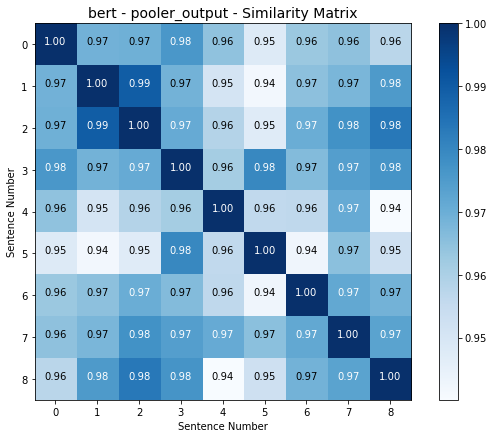

0 - The stained glass windows of Chartres Cathedral are held to be one of the best-preserved and most complete set of medieval stained glass.
1 - This limited the number of windows, leading to a play of light and shade which builders compensated for by adding internal frescoes in bright colours.
2 - In northern France buildings in this style would still be quite dark, with semi-circular arches not allowing large windows.
3 - Gymnastics is a type of sport that includes physical exercises requiring balance, strength, flexibility, agility, coordination, and endurance.
4 - This provides a firm surface that provides extra bounce or spring when compressed, allowing gymnasts to achieve greater height and a softer landing after the composed skill.
5 - In Tumbling, athletes perform an explosive series of flips and twists down a sprung tumbling track.
6 - Tinnitus is the perception of sound when no corresponding external sound is present.
7 - While often described as a ringing, it may also sound

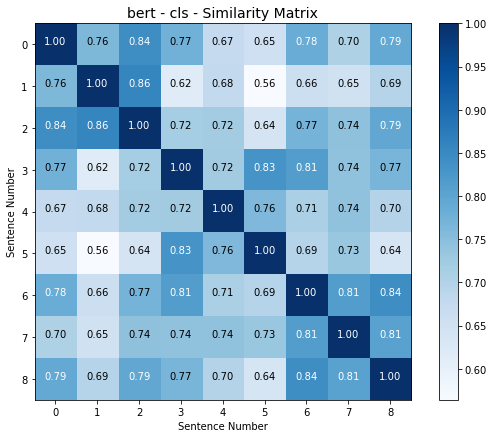

0 - The stained glass windows of Chartres Cathedral are held to be one of the best-preserved and most complete set of medieval stained glass.
1 - This limited the number of windows, leading to a play of light and shade which builders compensated for by adding internal frescoes in bright colours.
2 - In northern France buildings in this style would still be quite dark, with semi-circular arches not allowing large windows.
3 - Gymnastics is a type of sport that includes physical exercises requiring balance, strength, flexibility, agility, coordination, and endurance.
4 - This provides a firm surface that provides extra bounce or spring when compressed, allowing gymnasts to achieve greater height and a softer landing after the composed skill.
5 - In Tumbling, athletes perform an explosive series of flips and twists down a sprung tumbling track.
6 - Tinnitus is the perception of sound when no corresponding external sound is present.
7 - While often described as a ringing, it may also sound

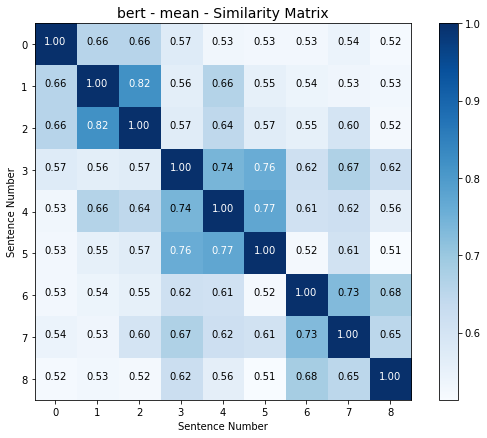

0 - The stained glass windows of Chartres Cathedral are held to be one of the best-preserved and most complete set of medieval stained glass.
1 - This limited the number of windows, leading to a play of light and shade which builders compensated for by adding internal frescoes in bright colours.
2 - In northern France buildings in this style would still be quite dark, with semi-circular arches not allowing large windows.
3 - Gymnastics is a type of sport that includes physical exercises requiring balance, strength, flexibility, agility, coordination, and endurance.
4 - This provides a firm surface that provides extra bounce or spring when compressed, allowing gymnasts to achieve greater height and a softer landing after the composed skill.
5 - In Tumbling, athletes perform an explosive series of flips and twists down a sprung tumbling track.
6 - Tinnitus is the perception of sound when no corresponding external sound is present.
7 - While often described as a ringing, it may also sound

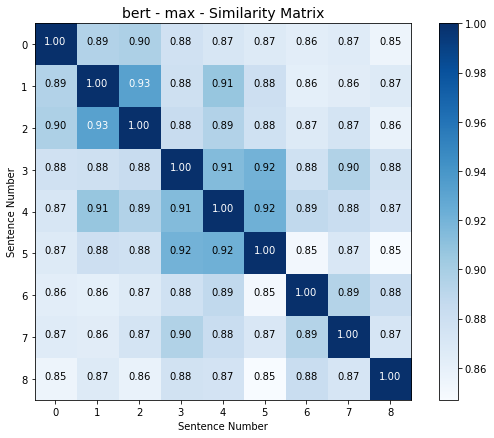

In [13]:
compare_sentence_embeddings(input_sentences, comparison="pooler_output", model="bert", absolute_range=False)
compare_sentence_embeddings(input_sentences, comparison="cls", model="bert", absolute_range=False)
compare_sentence_embeddings(input_sentences, comparison="mean", model="bert", absolute_range=False)
compare_sentence_embeddings(input_sentences, comparison="max", model="bert", absolute_range=False)

0 - The stained glass windows of Chartres Cathedral are held to be one of the best-preserved and most complete set of medieval stained glass.
1 - This limited the number of windows, leading to a play of light and shade which builders compensated for by adding internal frescoes in bright colours.
2 - In northern France buildings in this style would still be quite dark, with semi-circular arches not allowing large windows.
3 - Gymnastics is a type of sport that includes physical exercises requiring balance, strength, flexibility, agility, coordination, and endurance.
4 - This provides a firm surface that provides extra bounce or spring when compressed, allowing gymnasts to achieve greater height and a softer landing after the composed skill.
5 - In Tumbling, athletes perform an explosive series of flips and twists down a sprung tumbling track.
6 - Tinnitus is the perception of sound when no corresponding external sound is present.
7 - While often described as a ringing, it may also sound

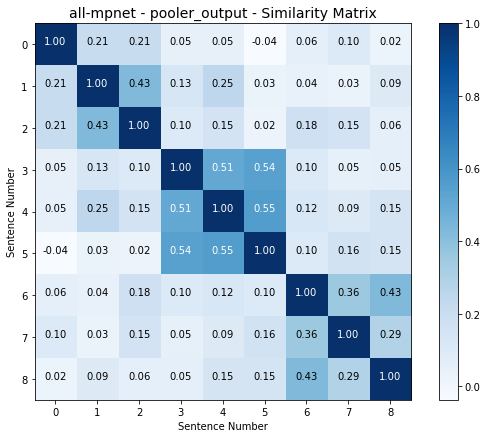

0 - The stained glass windows of Chartres Cathedral are held to be one of the best-preserved and most complete set of medieval stained glass.
1 - This limited the number of windows, leading to a play of light and shade which builders compensated for by adding internal frescoes in bright colours.
2 - In northern France buildings in this style would still be quite dark, with semi-circular arches not allowing large windows.
3 - Gymnastics is a type of sport that includes physical exercises requiring balance, strength, flexibility, agility, coordination, and endurance.
4 - This provides a firm surface that provides extra bounce or spring when compressed, allowing gymnasts to achieve greater height and a softer landing after the composed skill.
5 - In Tumbling, athletes perform an explosive series of flips and twists down a sprung tumbling track.
6 - Tinnitus is the perception of sound when no corresponding external sound is present.
7 - While often described as a ringing, it may also sound

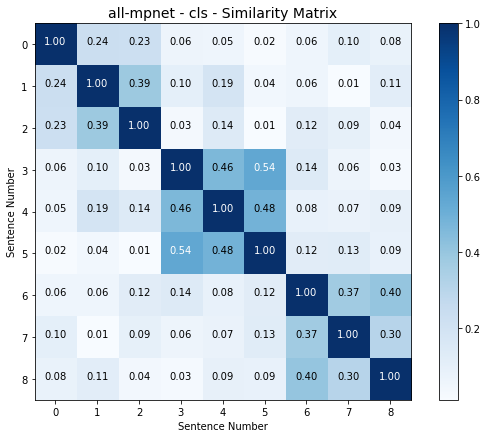

0 - The stained glass windows of Chartres Cathedral are held to be one of the best-preserved and most complete set of medieval stained glass.
1 - This limited the number of windows, leading to a play of light and shade which builders compensated for by adding internal frescoes in bright colours.
2 - In northern France buildings in this style would still be quite dark, with semi-circular arches not allowing large windows.
3 - Gymnastics is a type of sport that includes physical exercises requiring balance, strength, flexibility, agility, coordination, and endurance.
4 - This provides a firm surface that provides extra bounce or spring when compressed, allowing gymnasts to achieve greater height and a softer landing after the composed skill.
5 - In Tumbling, athletes perform an explosive series of flips and twists down a sprung tumbling track.
6 - Tinnitus is the perception of sound when no corresponding external sound is present.
7 - While often described as a ringing, it may also sound

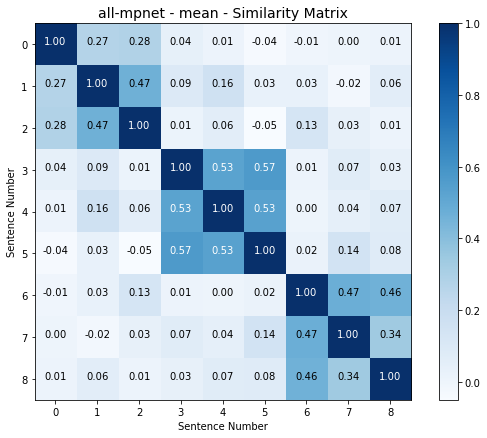

0 - The stained glass windows of Chartres Cathedral are held to be one of the best-preserved and most complete set of medieval stained glass.
1 - This limited the number of windows, leading to a play of light and shade which builders compensated for by adding internal frescoes in bright colours.
2 - In northern France buildings in this style would still be quite dark, with semi-circular arches not allowing large windows.
3 - Gymnastics is a type of sport that includes physical exercises requiring balance, strength, flexibility, agility, coordination, and endurance.
4 - This provides a firm surface that provides extra bounce or spring when compressed, allowing gymnasts to achieve greater height and a softer landing after the composed skill.
5 - In Tumbling, athletes perform an explosive series of flips and twists down a sprung tumbling track.
6 - Tinnitus is the perception of sound when no corresponding external sound is present.
7 - While often described as a ringing, it may also sound

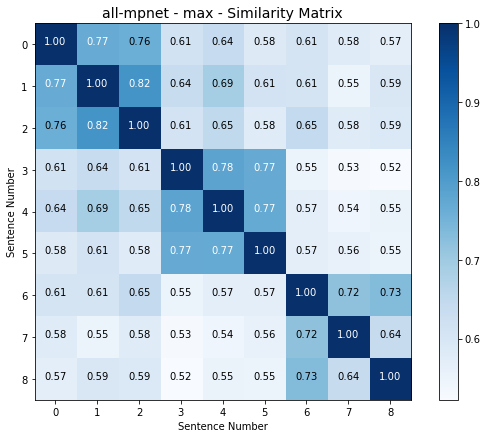

In [14]:
compare_sentence_embeddings(input_sentences, comparison="pooler_output", model="all-mpnet", absolute_range=False)
compare_sentence_embeddings(input_sentences, comparison="cls", model="all-mpnet", absolute_range=False)
compare_sentence_embeddings(input_sentences, comparison="mean", model="all-mpnet", absolute_range=False)
compare_sentence_embeddings(input_sentences, comparison="max", model="all-mpnet", absolute_range=False)

0 - The stained glass windows of Chartres Cathedral are held to be one of the best-preserved and most complete set of medieval stained glass.
1 - This limited the number of windows, leading to a play of light and shade which builders compensated for by adding internal frescoes in bright colours.
2 - In northern France buildings in this style would still be quite dark, with semi-circular arches not allowing large windows.
3 - Gymnastics is a type of sport that includes physical exercises requiring balance, strength, flexibility, agility, coordination, and endurance.
4 - This provides a firm surface that provides extra bounce or spring when compressed, allowing gymnasts to achieve greater height and a softer landing after the composed skill.
5 - In Tumbling, athletes perform an explosive series of flips and twists down a sprung tumbling track.
6 - Tinnitus is the perception of sound when no corresponding external sound is present.
7 - While often described as a ringing, it may also sound

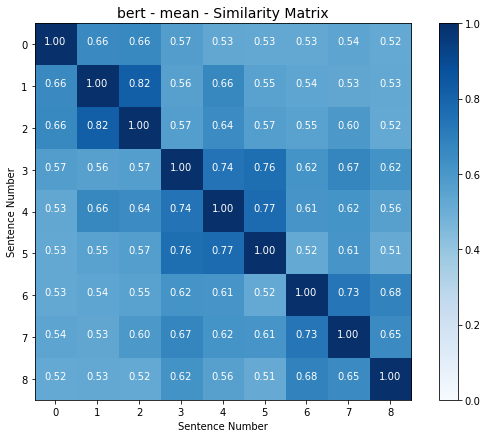

0 - The stained glass windows of Chartres Cathedral are held to be one of the best-preserved and most complete set of medieval stained glass.
1 - This limited the number of windows, leading to a play of light and shade which builders compensated for by adding internal frescoes in bright colours.
2 - In northern France buildings in this style would still be quite dark, with semi-circular arches not allowing large windows.
3 - Gymnastics is a type of sport that includes physical exercises requiring balance, strength, flexibility, agility, coordination, and endurance.
4 - This provides a firm surface that provides extra bounce or spring when compressed, allowing gymnasts to achieve greater height and a softer landing after the composed skill.
5 - In Tumbling, athletes perform an explosive series of flips and twists down a sprung tumbling track.
6 - Tinnitus is the perception of sound when no corresponding external sound is present.
7 - While often described as a ringing, it may also sound

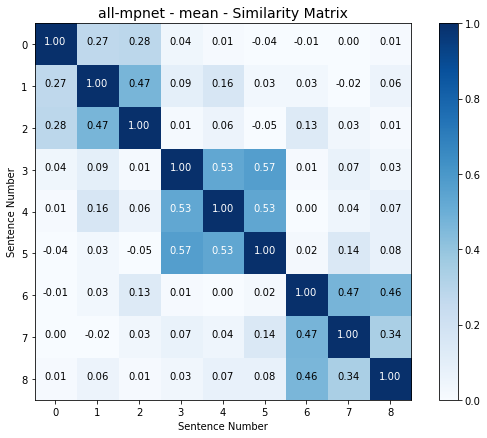

In [15]:
compare_sentence_embeddings(input_sentences, comparison="mean", model="bert", absolute_range=True)
compare_sentence_embeddings(input_sentences, comparison="mean", model="all-mpnet", absolute_range=True)

In [16]:
"here is a test".split()

['here', 'is', 'a', 'test']

In [17]:
import random
def sentence_permuter(sentence, num_to_generate=5):
    shuffled_sentences = []
    for i in range(num_to_generate):
        word_list = sentence.split()
        random.shuffle(word_list)
        shuffled_sentences.append(" ".join(word_list))
    return shuffled_sentences 

In [18]:
sentence_permuter("here is a test.")

['test. is a here',
 'test. a is here',
 'is test. here a',
 'here a is test.',
 'is here test. a']

In [19]:
shuffled_sentences = sentence_permuter(input_sentences[0])

0 - complete be of glass. one set of are glass stained Cathedral medieval windows The Chartres most stained held of best-preserved and to the
1 - Chartres are set windows Cathedral complete glass of stained of of glass. to The one most stained be the and best-preserved held medieval
2 - medieval be one of stained windows held glass. complete best-preserved stained to of glass most set Chartres the of and are Cathedral The
3 - and Cathedral most glass medieval best-preserved held one the windows Chartres set stained are glass. of The complete to of stained be of
4 - medieval held and Chartres stained complete be Cathedral windows of to most the The are glass. one of best-preserved set of glass stained


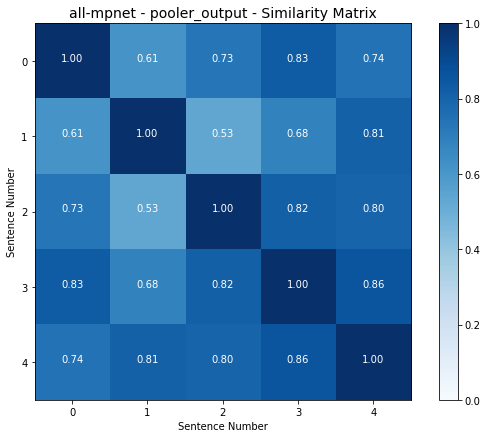

0 - complete be of glass. one set of are glass stained Cathedral medieval windows The Chartres most stained held of best-preserved and to the
1 - Chartres are set windows Cathedral complete glass of stained of of glass. to The one most stained be the and best-preserved held medieval
2 - medieval be one of stained windows held glass. complete best-preserved stained to of glass most set Chartres the of and are Cathedral The
3 - and Cathedral most glass medieval best-preserved held one the windows Chartres set stained are glass. of The complete to of stained be of
4 - medieval held and Chartres stained complete be Cathedral windows of to most the The are glass. one of best-preserved set of glass stained


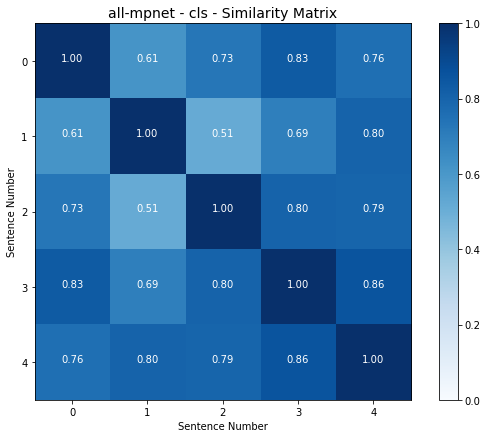

0 - complete be of glass. one set of are glass stained Cathedral medieval windows The Chartres most stained held of best-preserved and to the
1 - Chartres are set windows Cathedral complete glass of stained of of glass. to The one most stained be the and best-preserved held medieval
2 - medieval be one of stained windows held glass. complete best-preserved stained to of glass most set Chartres the of and are Cathedral The
3 - and Cathedral most glass medieval best-preserved held one the windows Chartres set stained are glass. of The complete to of stained be of
4 - medieval held and Chartres stained complete be Cathedral windows of to most the The are glass. one of best-preserved set of glass stained


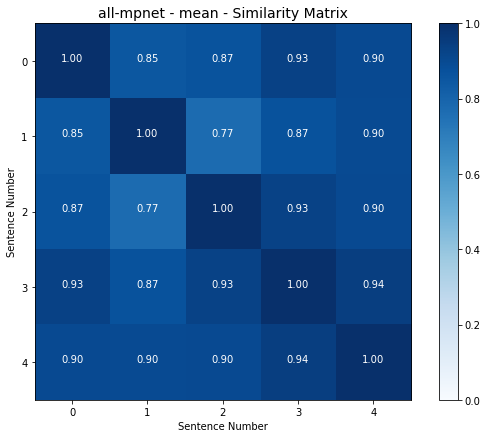

0 - complete be of glass. one set of are glass stained Cathedral medieval windows The Chartres most stained held of best-preserved and to the
1 - Chartres are set windows Cathedral complete glass of stained of of glass. to The one most stained be the and best-preserved held medieval
2 - medieval be one of stained windows held glass. complete best-preserved stained to of glass most set Chartres the of and are Cathedral The
3 - and Cathedral most glass medieval best-preserved held one the windows Chartres set stained are glass. of The complete to of stained be of
4 - medieval held and Chartres stained complete be Cathedral windows of to most the The are glass. one of best-preserved set of glass stained


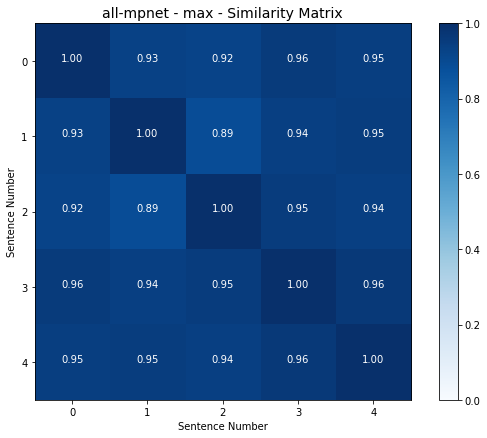

In [20]:
model_to_test = "all-mpnet"
compare_sentence_embeddings(shuffled_sentences, comparison="pooler_output", model=model_to_test, absolute_range=True)
compare_sentence_embeddings(shuffled_sentences, comparison="cls", model=model_to_test, absolute_range=True)
compare_sentence_embeddings(shuffled_sentences, comparison="mean", model=model_to_test, absolute_range=True)
compare_sentence_embeddings(shuffled_sentences, comparison="max", model=model_to_test, absolute_range=True)

In [21]:
with open("hobbit_body.txt", "r") as f:
    hobbit_text = f.read()
hobbit_text = hobbit_text.replace("\n", "")

In [22]:
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/aetasaam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [23]:
hobbit_sentences = nltk.sent_tokenize(hobbit_text)

In [24]:
hobbit_sentences[:5]

['Chapter I AN UNEXPECTED PARTY In a hole in the ground there lived a hobbit.',
 'Not a nasty, dirty, wet hole, filled with the ends of worms and an oozy smell, nor yet a dry, bare, sandy hole with nothing in it to sit down on or to eat: it was a hobbit-hole, and that means comfort.',
 'It had a perfectly round door like a porthole, painted green, with a shiny yellow brass knob in the exact middle.',
 'The door opened on to a tube-shaped hall like a tunnel: a very comfortable tunnel without smoke, with panelled walls, and floors tiled and carpeted, provided with polished chairs, and lots and lots of pegs for hats and coats — the hobbit was fond of visitors.',
 'The tunnel wound on and on, going fairly but not quite straight into the side of the hill — The Hill, as all the people for many miles round called it — and many little round doors opened out of it, first on one side and then on another.']

In [25]:
len(hobbit_sentences)

4861

In [26]:
import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


In [27]:
class SentenceDataset(Dataset):
    def __init__(self, sentences):
        self.sentences = sentences
        
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, idx):
        return self.sentences[idx]

In [28]:
hobbit_data = SentenceDataset(hobbit_sentences)
hobbit_dataloader = DataLoader(hobbit_data, batch_size=100, shuffle=False)

In [29]:
model = "all-mpnet"
comparison = "mean"
query_sentence = "The creature swam towards bilbo."
query_sentence = "The trolls turned into stone statues."
query_embedding = get_embedding(query_sentence, comparison, model)

similarities_list = []
for sentence_batch in tqdm.tqdm(hobbit_dataloader):
    key_embedding = get_embedding(sentence_batch, comparison, model)
    similarities_list.append(cos(query_embedding, key_embedding))
similarities = torch.concat(similarities_list)

100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s]


In [30]:
topk_indices = similarities.topk(5)
for position, index in enumerate(topk_indices.indices):
    print(f"{topk_indices.values[position]:.2f} - {hobbit_sentences[index]}")

0.59 - And there they stand to this day, all alone, unless the birds perch on them; for trolls, as you probably know, must be underground before dawn, or they go back to the stuff of the mountains they are made of, and never move again.
0.46 - The bushes, and the long grasses between the boulders, the patches of rabbit-cropped turf, the thyme and the sage and the marjoram, and the yellow rockroses all vanished, and they found themselves at the top of a wide steep slope of fallen stones, the remains of a landslide.
0.46 - A nice pickle they were all in now: all neatly tied up in sacks, with three angry trolls (and two with burns and bashes to remember) sitting by them, arguing whether they should roast them slowly, or mince them fine and boil them, or just sit on them one by one and squash them into jelly; and Bilbo up in a bush, with his clothes and his skin torn, not daring to move for fear they should hear him.
0.46 - When they began to go down this, rubbish and small pebbles rolled 